##1) 데이터 선정 이유 및 문제 정의

**<시나리오>**

>에어비앤비는 당사 서비스의 접근성을 높이기 위해, 뉴욕시를 시범 대상으로 정해진 방의 조건을 입력하면 연 $75000 이상의 매출 여부 예측(분류)해주는 모델을 만들어
방을 보유한 누구나 에어비앤비의 호스트로 뉴욕시 월 평균 소득 이상을 벌 수 있는지 확인할 수 있는 분류 모델을 제공하여 신규 호스트들을 유입시키고자 한다

##2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택
- 해당 특성을 target으로 지정한 이유를 설명하세요
- 해당 베이스라인 모델과 평가지표를 선택한 이유를 설명하세요

In [1]:
target = 'Goal_price' #1년 매출이 $75000 이상일지 여부 예측 feature

In [2]:
#baseline model : 하이퍼 파라미터 튜닝 이전의 모델

**하이퍼파라미터 튜닝, 데이터 전처리 전의 xgbclassifier(baseline model)**

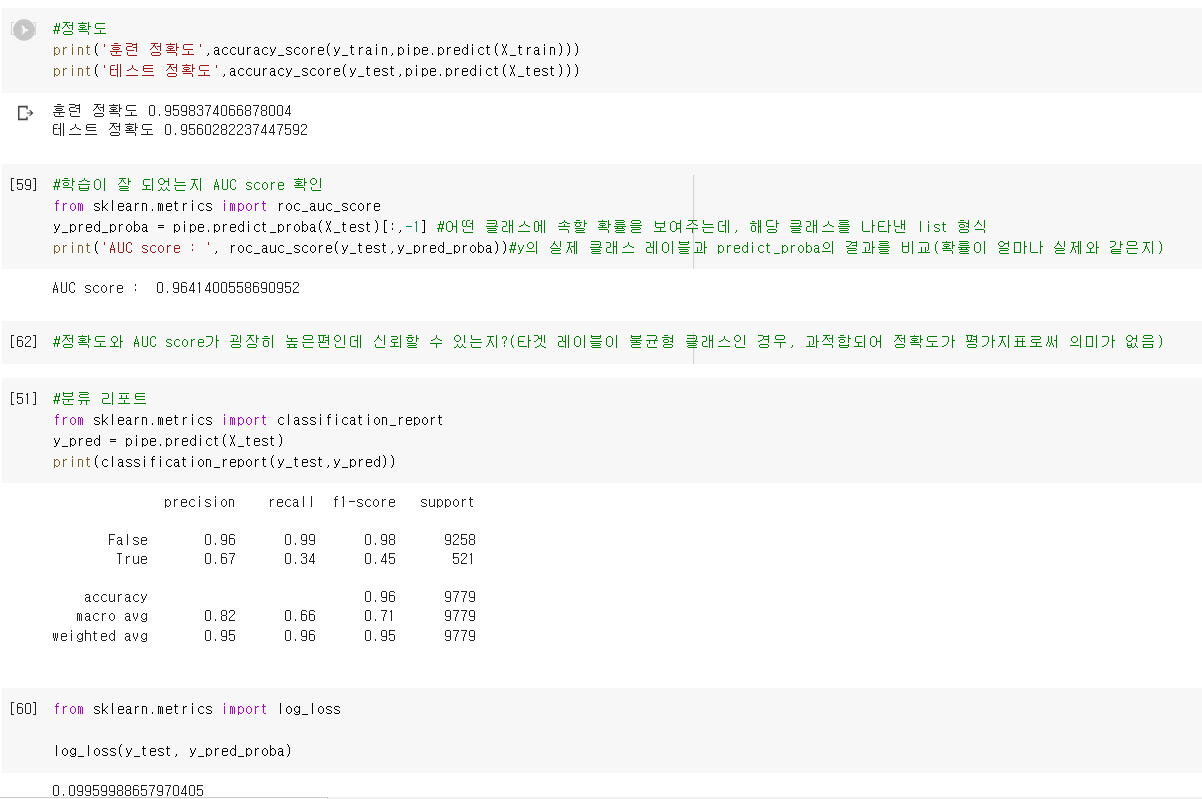

In [3]:
#평가지표 : f1_score(사용한 데이터는 불균형 클래스 데이터로써, 정확도만 사용해서는 모델의 성능을 알기 어려움.)

##3) EDA와 데이터 전처리

(EDA, Feature Engineering, 데이터의 정규화, 노이즈 제거, 결측치 제거 혹은 대체, 데이터 밸런스, 그 외)
- Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?

- 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?

##4) 머신러닝 방식 적용 및 교차검증

> Linear / Tree-based / Ensemble 모델을 학습하세요. (다양하게 시도해보시는 걸 추천합니다.)

> 평가지표를 계산 후 베이스라인과 비교해보세요.

> 어느정도 성능이 나왔다면, 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인해봅니다.

>모델 성능을 개선하기 위한 다양한 방법을 적용해보세요.
Hyperparameter tuning, etc.

> 최소 2개 이상의 모델을 만들어서 validation 점수를 보고하세요.

> 최종 모델의 test 점수를 보고하세요.

- 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
- 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
- 최종 모델에 관해 설명하세요.



##5) 머신러닝 모델 해석

>PDP, SHAP을 활용하여 최종 모델을 설명합니다

>시각화는 "설명"이 제일 중요합니다.

- 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
- 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?

**1. 데이터 EDA(feature, 결측치 등 데이터 특징 확인)**

In [4]:
#install list
#!pip install category_encoders
#!pip install pdpbox
#!pip install shap
#!pip install -U pandas-profiling
#!pip install pdpbox
#!pip install shap

In [5]:
### 데이터 세트 : New York City Airbnb Open Data ###

#뉴욕 에어비앤비에서 연 $75000 이상 창출 가능한지 예측(분류)하는 모델 만들기
#https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv

import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
#데이터셋 불러오기
data = pd.read_csv('/content/drive/MyDrive/kaggle/AB_NYC_2019.csv')
print('rows,columns :',data.shape)
data.head(3)

rows,columns : (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [7]:
#profile report로 데이터 확인
from pandas_profiling import ProfileReport

report = ProfileReport(data)
#report

**feature별 결측치**

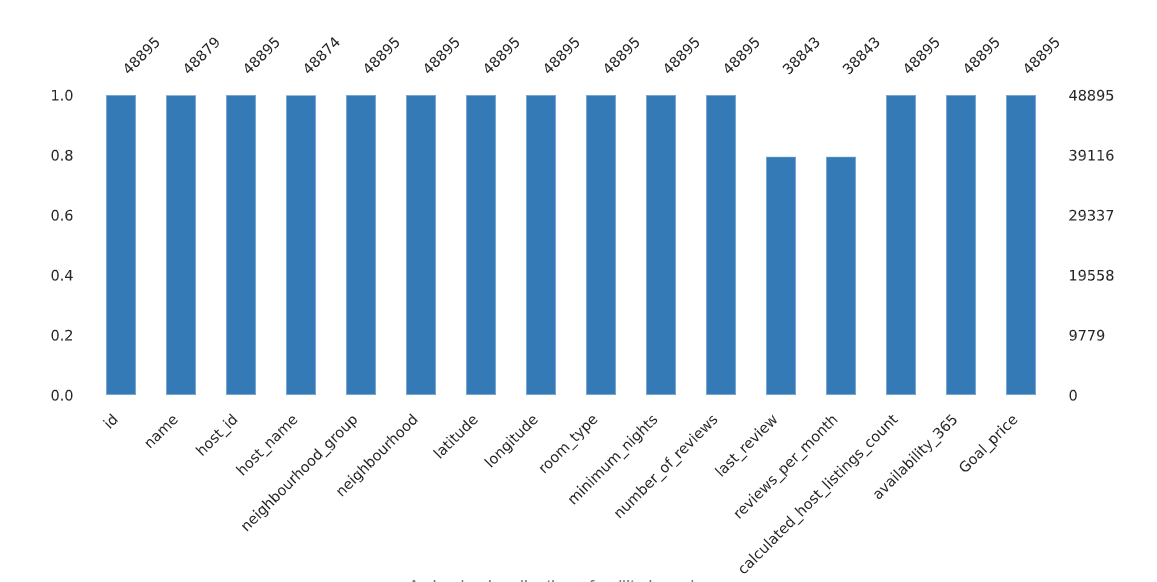

**특성별 정보**

- id : 방의 구분 번호
- name : 호스트가 지정한 방의 이름
- host_id : 호스트 구분 번호
- host_name : 호스트 이름
- neighbourhood_group : 자치구명
- neighbourhood : 자치구 내 세부 지역명
- latitude : 지역 위도 좌표
- longitude : 지역 경도 좌표
- room_type : 방 유형
- price : 달러 가격(target)
- minimum_nights : 최소 숙박일 수
- number_of_reviews : 리뷰 총 개수
- last_review : 가장 최신 리뷰 날짜
- reviews_per_month : 월 리뷰수
- calculated_host_listings_count : 호스트 별 방의 개수
- availability_365 : 1년(365일) 중 예약 가능한 일수

**2. 데이터 전처리(data wrangling, preprocessing)**

In [8]:
#target feature만들기(연 $75000 달러 이상인지?)
data['Goal_price'] = (data['price']*data['availability_365']) >= 75000
data['Goal_price'].value_counts(normalize=True)

False    0.946702
True     0.053298
Name: Goal_price, dtype: float64

In [9]:
#전체 데이터에서 price 삭제하기
data = data[data.drop(columns=['price']).columns]

In [10]:
data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Goal_price
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,2018-10-19,0.21,6,365,False
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2019-05-21,0.38,2,355,True
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,3,0,NaN,NaN,1,365,False


In [11]:
### 라이브러리 import  ### 
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

#평가지표 라이브러리
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#시각화 라이브러리
import shap
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
#결측값 채워넣기

data['last_review'] = data['last_review'].fillna('DontKnow')
data['last_review'].isna().sum()

0

In [14]:
#결측값 채워넣기

data['reviews_per_month'] = data['reviews_per_month'].fillna(0)
data['reviews_per_month'].isna().sum()

0

In [15]:
#의미있는 feature 새로 만들기
#타임스퀘어가 위치한 'Manhattan' 지역인 방 여부(위도,경도로 나누려 했으나 자치구가 달라져도 위도,경도 차이가 미세함.)
data['neighbourhood_group']=='Manhattan'
data['timessquare_zone'] = data['neighbourhood_group']=='Manhattan'

**3. 검증 방식에 따라 데이터 분할**

In [16]:
#target 나누기(X,y)
X = data[data.drop(columns=[target]).columns]
y = data[target]

In [17]:
#데이터 세트 분할

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2,random_state=2)

X_train.shape,X_val.shape, X_test.shape

((31292, 16), (7824, 16), (9779, 16))

**4. 파이프라인 구축 및 평가지표 확인(f1_score), 하이퍼 파라미터 튜닝**

In [18]:
#gradient boosting model 파이프라인 구축
pipe = make_pipeline(
    OrdinalEncoder(),#범주가 다양한 범주형 feature들이 많아서 ordinalencoder 사용
    SimpleImputer(), #결측치 일괄적으로 채우는 라이브러리
    XGBClassifier(random_state=2) #가장 많이 쓰이는 gradient boosting classifier 라이브러리
)
pipe.fit(X_train,y_train)
#정확도
print('baseline model 훈련 정확도',accuracy_score(y_train,pipe.predict(X_train)))
print('baseline model 검증 정확도',accuracy_score(y_val,pipe.predict(X_val)))
print('baseline model 검증 일반화 성능 점수',f1_score(y_val,pipe.predict(X_val),average='macro')) #분류 성능 평가
from sklearn.metrics import roc_auc_score
y_pred_proba = pipe.predict_proba(X_val)[:,-1] #어떤 클래스에 속할 확률을 나타낸 list 형식
print('baseline model AUC score : ', roc_auc_score(y_val,y_pred_proba)) #학습이 잘 된 정도(1에 가까울수록 학습이 잘된 것)

baseline model 훈련 정확도 0.9606928288380416
baseline model 검증 정확도 0.9565439672801636
baseline model 검증 일반화 성능 점수 0.725510282839481
baseline model AUC score :  0.9620432931668039


In [19]:
#XGBClassifier의 경우 정확도는 높은데 반해 F1 score가 0.72 정도로 나온걸로 보아 일반화 성능(분류 성능)이 좋다고 보기 어렵다.(과적합 의심)

In [20]:
#하이퍼파라미터 튜닝 이후

pipe = Pipeline([('preprocessing',make_pipeline(
    OrdinalEncoder(),#범주가 다양한 범주형 feature들이 많아서 ordinalencoder 사용
    SimpleImputer())), #결측치 일괄적으로 채우는 라이브러리
    ('xgb',XGBClassifier(n_estimators=160, #가장 많이 쓰이는 gradient boosting classifier 라이브러리
                  learning_late=0.2,
                  max_depth=8,
                  n_jobs=-1,
                  scale_pos_weight=4,
                  random_state=2) 
)])
pipe.fit(X_train,y_train)
#정확도
print('model 훈련 정확도',accuracy_score(y_train,pipe.predict(X_train)))
print('model 검증 정확도',accuracy_score(y_val,pipe.predict(X_val)))
print('model 검증 일반화 성능 점수',f1_score(y_val,pipe.predict(X_val),average='macro')) #분류 성능 평가
from sklearn.metrics import roc_auc_score
y_pred_proba = pipe.predict_proba(X_val)[:,-1] #어떤 클래스에 속할 확률을 나타낸 list 형식
print('model AUC score : ', roc_auc_score(y_val,y_pred_proba)) #학습이 잘 된 정도(1에 가까울수록 학습이 잘된 것)

model 훈련 정확도 0.9912437683753036
model 검증 정확도 0.9612730061349694
model 검증 일반화 성능 점수 0.8091976249664883
model AUC score :  0.9667994318727475


In [21]:
#f1_score 리포트
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      7396
        True       0.65      0.63      0.64       428

    accuracy                           0.96      7824
   macro avg       0.82      0.80      0.81      7824
weighted avg       0.96      0.96      0.96      7824



In [22]:
#randomforest model 파이프라인 구축

pipe2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=2)
)

pipe2.fit(X_train,y_train)

print('baseline model 훈련 정확도',accuracy_score(y_train,pipe2.predict(X_train)))
print('baseline model 검증 정확도',accuracy_score(y_val,pipe2.predict(X_val)))
print('baseline model 검증 일반화 성능 점수',f1_score(y_val,pipe2.predict(X_val),average='macro'))
from sklearn.metrics import roc_auc_score
y_pred_proba = pipe2.predict_proba(X_val)[:,-1]
print('baseline model AUC score : ', roc_auc_score(y_val,y_pred_proba))

baseline model 훈련 정확도 1.0
baseline model 검증 정확도 0.9596114519427403
baseline model 검증 일반화 성능 점수 0.7529256573635106
baseline model AUC score :  0.9466058629822637


In [23]:
#RandomForestClassifier는 정확도가 1(최고점)이 나오고 전반적인 정확도는 매우 높은 반면에 마찬가지로 F1 score가 0.75가 나오면서 
#과적합이 의심되고 일반화 성능, 즉 분류 성능이 좋다고 보기 어렵다.

In [24]:
#하이퍼 파라미터 튜닝 이후

pipe2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(max_depth=30,
                           n_estimators=40,
                           n_jobs=-1,
                           min_samples_split=3,
                           class_weight={0:7,1:2},
                           oob_score=True,
                           random_state=2)
)

pipe2.fit(X_train,y_train)

print('model 훈련 정확도',accuracy_score(y_train,pipe2.predict(X_train)))
print('model 검증 정확도',accuracy_score(y_val,pipe2.predict(X_val)))
print('model 검증 일반화 성능 점수',f1_score(y_val,pipe2.predict(X_val),average='macro'))
from sklearn.metrics import roc_auc_score
y_pred_proba = pipe2.predict_proba(X_val)[:,-1]
print('model AUC score : ', roc_auc_score(y_val,y_pred_proba))

model 훈련 정확도 0.998306276364566
model 검증 정확도 0.9587167689161554
model 검증 일반화 성능 점수 0.7928729466292653
model AUC score :  0.9413946601598236


In [22]:
#randomizedsearchCV를 통해 하이퍼 파라미터 튜닝, 교차 검증(xgboost model)

from scipy.stats import randint, uniform
import numpy as np


param_xgbc = {   
    'simpleimputer__strategy': ['mean', 'median'], 
    'xgbclassifier__n_estimators': [100,150,200,300]
    'xgbclassifier__learning_late': [0.2,0.01,0.001], #default=0.1
    'xgbclassifier__max_depth': [3,5,7,10,15]
}

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')
         
rds = GridSearchCV(pipe, param_grid=param_xgbc, scoring='f1', cv=3, n_jobs=-1)

rds.fit(X_train, y_train)

print("최적의 매개변수: {}".format(rds.best_params_))
print("검증 일반화 성능 점수: {:.2f}".format(rds.score(X_val, y_val)))

최적의 매개변수: {'xgbclassifier__n_estimators': 300, 'xgbclassifier__max_depth': 11, 'xgbclassifier__learning_late': 0.001}
검증 일반화 성능 점수: 0.59


In [234]:
#randomizedsearchCV를 통해 하이퍼 파라미터 튜닝, 교차 검증(randomforest model)

from scipy.stats import randint, uniform
import numpy as np


param_rf = {   
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': [10,50,100], 
    'randomforestclassifier__min_samples_leaf': np.arange(1,100,10),
    'randomforestclassifier__max_depth': [3,5,7,10,15]
}

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')
         
rds = RandomizedSearchCV(pipe2, param_distributions=param_rf, scoring='f1',n_iter=30, cv=3, n_jobs=-1)

rds.fit(X_train, y_train)

print("최적의 매개변수: {}".format(rds.best_params_))
print("검증 일반화 성능 점수: {:.2f}".format(rds.score(X_val, y_val)))

최적의 매개변수: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 10, 'randomforestclassifier__min_samples_leaf': 11, 'randomforestclassifier__max_depth': 10}
검증 일반화 성능 점수: 0.49


- f1_score는 정밀도와 재현율의 조화 평균으로써 정밀도는 얼마나 잘 예측했는지(예측이 정답일 확률), 재현율은 정답중에서 실제 정답의 비율(맞는 예측을 한 비율)

- f1_score를 통해 일반화 성능(분류 성능)을 확인한 결과, baseline model 비교에서는 randomforest가 더 높은 성능을 보였으나 randomforest는 하이퍼 파라미터 튜닝에도 성능 점수 변화가 미미하고, xgboost는 하이퍼 파라미터 튜닝에 민감하여 성능 향상의 여지가 많기때문에 xgboost를 분류 모델로 사용하기로 함.

In [101]:
#target feature인 'Goal_price'를 만들고나서 'availability_365'를 지우지않아서 data leakage가 일어났을 가능성이 크므로 삭제 => 삭제했더니 f1_score 하향됨(기각)
#결측치가 다수 존재하는 'last_review','reviews_per_month' feature들은 삭제
#뉴욕시에서 타임스퀘어 주변이 편의시설이 많고 가장 번화하므로 타임스퀘어가 위치한 'Manhattan' 지역 여부도 feature로 생성..?

In [25]:
### 최종 test 정확도 ###

print('테스트 정확도',accuracy_score(y_test,pipe.predict(X_test)))
y_test_pred = pipe.predict(X_test)
print('분류 성능(f1_score) : ',f1_score(y_test,y_test_pred,average='macro'))#클래스별 가중치를 달리하는 보편적 macro f1_score로 평가

테스트 정확도 0.9584824624194703
분류 성능(f1_score) :  0.7945908801747625


In [26]:
#데이터가 불균형하므로 Stratified k-fold cross validation(이하 skf cv) 실행
#일반적인 K-fold cross validation을 실행할 때, 클래스가 불균형한 데이터의 경우 정말 랜덤한 데이터 검증을 실시하기 때문에
#어느 클래스는 검증에서 제외되거나 하는 경우로 인해 제대로 된 일반화 성능을 검증할 수 없으므로 skf cv를 실행할 경우 모든 클래스를 같은 비율로 검증하기 때문에
#불균형 클래스의 경우 skf cv를 사용한다.
#사이킷런에서는 교차 검증 정확도를 제공하는 API가 존재하는데 기본적으로 skf cv 방식을 사용하기 때문에 해당 API를 사용하여 교차검증 평균 정확도를 확인함.
from sklearn.model_selection import cross_val_score, cross_validate


score = cross_val_score(pipe,X_train,y_train,scoring='f1_macro',cv=5)

print('일반화 성능 교차검증 정확도 : ',score.mean())

일반화 성능 교차검증 정확도 :  0.7555602915102393


**6. 시각화(PDP, shap) 진행 및 모델 설명**

In [27]:
#!pip install eli5

In [28]:
#특성중요도 확인
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['xgb'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [29]:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, #모든 특성 
    feature_names=feature_names)

Weight,Feature
0.0581 ± 0.0022,availability_365
0.0165 ± 0.0033,room_type
0.0107 ± 0.0038,longitude
0.0085 ± 0.0009,minimum_nights
0.0051 ± 0.0015,latitude
0.0031 ± 0.0015,host_name
0.0028 ± 0.0010,host_id
0.0022 ± 0.0017,id
0.0020 ± 0.0006,calculated_host_listings_count
0.0013 ± 0.0013,number_of_reviews


In [55]:
X_val.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
timessquare_zone                     bool
dtype: object

In [66]:
#PDP(feature2)
 

#비교2
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['latitude','longitude']

inter = pdp_interact(
    model = pipe,
    dataset = X_train,
    model_features = X_train.columns,
    features = features
)
pdp_interact_plot(inter, plot_type = 'grid',feature_names = features)


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f12ef4edbd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f12ef024490>})

In [97]:
import xgboost
import shap

row = X_test.iloc[[3700]]
model = pipe.named_steps['xgb']
processor = pipe.named_steps['preprocessing']

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)


In [96]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_encoded)

In [92]:
import shap
shap.summary_plot(shap_values, X_val_encoded, plot_type="bar");


## <최종 평가 항목>

1. 학습이 잘 된 모델인지(가설을 잘 분류해내는지)
2. 과적합이 된건 아닌지(모델이 일반화가 잘 되었는지)
3. data leakage는 없었는지(위와 같은 맥락으로 지나치게 높은 정확도, 훈련 데이터보다 현저히 낮은 검증 데이터의 f1_score 등을 확인해야함)

※data leakage 란?
:모델의 학습시에 타겟의 정보가 노출될만한 특성(feature)이 있거나, 타겟 정보가 없이는 알기 어려운 정보들이 포함되어 타겟이 유출된 것이나 다름없는 경우를 이름.
(ex, 시험 정보 유출) 